# 1. Instalamos las  dependencias

In [1]:
%pip install datasets huggingface_hub seaborn
#Si hay disponible una tarjeta gráfica:
!nvidia-smi -L
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
  %pip install llama-cpp-python
else:
  print(gpu_info)
  %pip install llama-cpp-python --prefer-binary --no-cache-dir --extra-index-url=https://jllllll.github.io/llama-cpp-python-cuBLAS-wheels/AVX2/cu116



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 36.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.8 MB/s eta 0:00:00
GPU 0: Tesla T4 (UUID: GPU-df7c60ae-d467-43a7-213b-8acfbd6071af)
Wed Nov  1 18:40:07 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla

# 2. Descargamos el dataset y el modelo

In [2]:
from llama_cpp import Llama
from datasets import load_dataset
from huggingface_hub import hf_hub_download
# Descargamos un dataset de huggingface.com usando la librería datasets
dataset = load_dataset("mesmalif/amazon-shoe-reviews")
# Seleccionamos un conjunto de test de ese dataset.
test_dataset = dataset["test"].to_iterable_dataset()

# Este el nombre del modelo que vamos a utitilizar también de huggingface
# usando la librería huggingface_hub
model_name_or_path = "TheBloke/CodeLlama-7B-Instruct-GGUF"
model_basename = "codellama-7b-instruct.Q4_K_M.gguf"
# model_name_or_path = "TheBloke/Llama-2-7b-Chat-GGUF"
# model_basename = "llama-2-7b-chat.Q4_K_M.gguf"
model_path = hf_hub_download(repo_id=model_name_or_path, filename=model_basename,)
llm = Llama(model_path=model_path,
n_ctx=1000,
n_gpu_layers=50, #Sólo para GPU
n_gqa=8)

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/90000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

codellama-7b-instruct.Q4_K_M.gguf:   0%|          | 0.00/4.08G [00:00<?, ?B/s]

AVX = 1 | AVX2 = 1 | AVX512 = 0 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | FMA = 1 | NEON = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 1 | SSE3 = 1 | SSSE3 = 1 | VSX = 0 | 


# 3. Cargamos el dataset en un Dataframe y lo preparamos para procesar el análisis

In [3]:
import pandas as pd
df = pd.json_normalize(test_dataset)
df = df.sample(frac=0.003)
df.reset_index(drop=True, inplace=True)
df['review'] = df['review_headline'] + ". " + df['text']
df['star_rating'] = df['labels'] + 1
df['prediction'] = None
df.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,labels,helpful_votes,total_votes,vine,verified_purchase,review_headline,text,review_date,review,star_rating,prediction
0,US,50145182,R29HRVT7Y82S9D,B000BO62HK,27010058,Propet Women's Tour Walker Strap Sneaker,Shoes,2,0,0,0,1,"Were the wrong size, returned them","these were the wrong size, but looked great, r...",2015-08-25,"Were the wrong size, returned them. these were...",3,None
1,US,23387672,R18JW1CV2NVO76,B00JO9SIPC,15890880,E-Dream New Fashion Lady Shoulder Bag Messenge...,Shoes,0,2,2,0,1,One Star,Went in trash immediately.,2015-07-15,One Star. Went in trash immediately.,1,None
2,US,25512081,R2111BME8KD3NG,B0044GAOYS,304013970,Vionic Women's Relax Slipper,Shoes,0,0,0,0,1,They were the worst slippers I have ever worn ...,They were the worst slippers I have ever worn ...,2015-07-27,They were the worst slippers I have ever worn ...,1,None
3,US,19878960,R15236BW89L2IZ,B0035LCDZG,743054468,Dansko Men's Wynn Slip-On Clog,Shoes,0,0,2,0,1,Beware,Not worth the headache of working with shoegis...,2015-08-30,Beware. Not worth the headache of working with...,1,None
4,US,24037015,RGAHUYSRIK74U,B0020H7HPC,826562181,Dr. Scholl's Men's Cambridge Work Athletic Shoe,Shoes,1,0,0,0,1,To Large,The shoes are fine as to the quality of show.<...,2015-08-14,To Large. The shoes are fine as to the quality...,2,None


In [4]:
import json
def parse_response(response):
        if type(response) == dict:
            if response.keys().__contains__("choices"):
                return parse_response(response["choices"][0])
            elif response.keys().__contains__("text"):

                return parse_response(response["text"])
            else:
                return response

        if type(response) == str:
            return json.loads(clean_response(response))


def clean_response(response):

    start = response.find("{")
    end = response.rfind("}") + 1
    temp = response[start:end]
    temp = temp.replace("'", '"')
    temp = temp.replace(": False,", ': "False",')
    temp = temp.replace(": True,", ': "True",')
    return temp


## 4. Procesamos el dataset y actualizamos los valores en el Dataframe

In [5]:
import time
import json
start = time.time()
count = 0

for i in range(df.shape[0]):
    reviewText = df.at[i, 'review']
    categoria = df.at[i,'product_category']
    prompt =f'[INST] Return a json with the following information extracted from the {categoria} review below you can find the review between triple backticks: \
    {{ \
        "Sentiment": "(Positive or Negative)",\
        "Stars": "Number of stars depending on the sentiment of the Review",\
        "Anger": "Is the user angry (True or False)", \
        "Product": "The name of the product reviewed", \
        "Brand": "The brand name of the product reviewed", \
        "Product type": ""The type of the product reviewed", \
        "Language": "The language of the review in ISO 639-1 format" \
    }} \
Review: ```' + \
reviewText + \
'``` \
If the information is not present, use ""unknown"" as the value. \
Remember to return only the json. \
[/INST]'
    output = llm(prompt, echo=False)
    try:
        response = parse_response(output)
        df.at[i,"prediction"] = int(response["Stars"])
    except:
        print("Error procesando reseña: ", reviewText)
end = time.time()
print((end - start)/60)

Llama.generate: prefix-match hit
Llama.generate: prefix-match hit


Error procesando reseña:  They were the worst slippers I have ever worn caused my foot to .... They were the worst slippers I have ever worn caused my foot to go out of balance, could not walk on left foot for 2 days.  Would not recommend these slippers....


Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit


Error procesando reseña:  when holding the grip area, it cut into my .... when holding the grip area, it cut into my hand ... it needs to be rounded.  I thought about wrapping duct tape around the grip -


Llama.generate: prefix-match hit


Error procesando reseña:  Super cute & ComFortAble. Super cute & ComFortAble! Got lots of compliments as well. I can't wear flat heeled shoes due to plantar fasciitis, so the heel is perfect, but also to me it feels more like a 2.50 inch rather than a 3 inch, which is fine, as I can walk in these all day without my feet getting sore. (I used to own another pair of Clarks that were 2.50 inch heel (I wore them out!!!-so these were replacements). Anyways.. Another great comfortable, stylish product of Clarks.


Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit


Error procesando reseña:  Five Stars. Great fit. Comfortable and Water resistant. Marvelous shoes


Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit


Error procesando reseña:  Four Stars. I bought this shoes for my mother and she like it.


Llama.generate: prefix-match hit


Error procesando reseña:  New Balance shoes lack conformity when it comes to the size and width of their shoes.. I purchased these shoes based on my New Balance tennis shoes MC656WN size 13 2E that I own.  MC696 (same size) are clearly smaller.  They are clearly narrower that the MC656WN.  You would think New Balance would have some conformity in the sizes of there shoes.  It makes it difficult to buy shoes over the internet.  I.m am returning these shoes today.  I tried these shoes on on 3 different occasions they are too small.


Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit


Error procesando reseña:  Narrower than a gun rights poll and less comfortable than having Caitlin Jenner send you lap pictures. Steve Martin's Cruel Shoes, look no further.  Narrower than a gun rights poll and less comfortable than having Caitlin Jenner send you lap pictures.  I drive a car with a manual; it is indeed rad when that top of one's foot goes into that &#34;f**k where's the blood?&#34; ache pain about 7 minutes into a 45 minute drive.  Protocol became put the shoes on at the office.<br /><br />The leather has creased and wadded up across the top.  That smooth toe you see up there at 11 o'clock looks like an old man's mule after three multi terminal airport hikes.  It is wild how much pain an old man's mule can inflict on one's feet.  That might be at Sundance next year, folks.<br /><br />It gets two stars because they cost $145 and my feet said two if they never have to have them on again.  So I agreed.


Llama.generate: prefix-match hit
Llama.generate: prefix-match hit


Error procesando reseña:  Three Stars. Inside sole kept coming out after getting wet but i just pulled them out and continued on.


Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit


1.1606440186500548


## 5. Mostramos la matriz de confusión

In [6]:
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'
from sklearn.metrics import confusion_matrix
import seaborn as sn

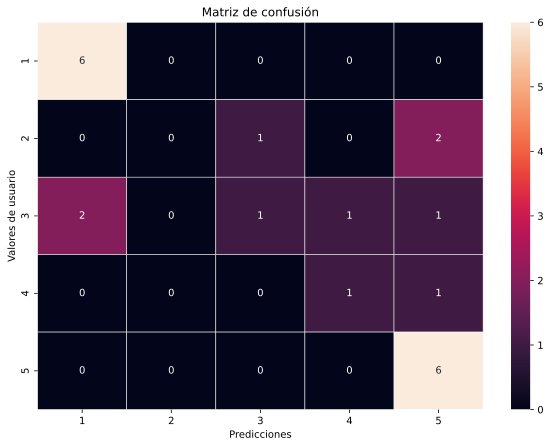

In [7]:
df_drop = df.replace('', np.nan)
df_drop = df_drop.dropna(subset=['prediction','star_rating'])
df_drop = df_drop.astype({'prediction': 'int', 'star_rating': 'int'})

array = confusion_matrix(y_true=df_drop['star_rating'], y_pred=df_drop['prediction'], labels = [1,2,3,4,5])

df_cm = pd.DataFrame(array, index = [i for i in [1,2,3,4,5]],
                  columns = [i for i in [1,2,3,4,5]])

plt.figure(figsize = (10,7))
ax = plt.axes()
sn.heatmap(df_cm, annot=True, fmt="d", linewidths=.5, ax=ax)
ax.set_title(f'Matriz de confusión')
ax.set_xlabel('Predicciones')
ax.set_ylabel('Valores de usuario')
plt.show()